# isoformsFromFLAIR.ipynb
## Marcus Viscardi,    January 21, 2023

So on Friday Jan 20th, I reran the pipelines for all four new libs and the two pilot libraries with the tag for FLAIR analysis turned on. Here I want to try and dig into those FLAIR outputs and see if I can pick out any isoform dependent effects such as NMD-sensitivity, or tail length differences!

Large detail here. FLAIR adds a transcript_id tag, but this doesn't necessarily match the gene_id tag carried over from featureCounts (I *think*). This means I'll need to add a step to "back calculate" the gene_id/_name

In [1]:
import os
import sys
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
import nanoporePipelineCommon as npCommon
from nanoporeReadPlotting.finalizingReadAndCoveragePlotting_matplotlib import plot_reads, coverage_plotting_5tera

import pandas as pd
import seaborn as sea
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product

CONVERSION_DICT = {"xrn-1-5tera": "oldN2",
                   "xrn-1-5tera-smg-6": "oldS6",
                   "5tera_xrn-1-KD_wt": "newN2",
                   "5tera_xrn-1-KD_smg-5": "newS5",
                   "5tera_xrn-1-KD_smg-6": "newS6",
                   "5tera_xrn-1-KD_smg-7": "newS7",
                   }
REV_CONVERSION_DICT = {val: key for key, val in CONVERSION_DICT.items()}

print(f"Imports done at {npCommon.get_dt(for_print=True)}")

Imports done at 01/24/23 @ 04:00:39 PM


# First lets check to see if my usual method and the FLAIR method at least assigned things to the same genes!

The detail here is that I need to reverse look up the gene_id from the transcript_id that FLAIR provided!!

So, messing around with the FLAIR dataframe has helped me realize/remember an issue. The FLAIR outputs only spit out read_id and transcript_id (at least in the way that I hacked it together). This means that any multimapping reads will have no means to resolve which assignment went with which map! This isn't a large scale issue at the moment, in this case (newN2) I can see 76.5k reads that match gene_ids from gene analysis and FLAIR, but ~18.3k are assigned by FLAIR but not my method, another ~500 reads are explicitly mismatched between the methods. I can toss everything besides the 76.5k out of 95.3k reads

For now, we will go with the conservative method, throw out everything that doesn't perfectly match. Maybe I'll have this spit out a percentage lost when doing this for my records.

In [2]:
from typing import List

def load_flair_and_filter_assignments_with_genes(target_lib_name: str) -> pd.DataFrame:
    # Load the transcripts tsv and the genes parquet:
    lib_txns_df = npCommon.adjust_5_ends(pd.read_table(npCommon.pick_lib_return_path(target_lib_name, file_midfix='_mergedWithTranscripts', file_suffix='.tsv'))).set_index('read_id')
    lib_genes_df = npCommon.adjust_5_ends(pd.read_parquet(npCommon.pick_lib_return_path(target_lib_name, file_midfix='_mergedOnReads', file_suffix='.parquet'))).set_index('read_id')
    # Also load my pre-parsed gtf file which will allow us to convert the FLAIR transcript_id to gene_ids/_names/_biotypes!
    gtf_df = pd.read_parquet("/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.gtf.parquet")[['chr', 'feature', 'gene_id', 'gene_name', 'gene_biotype', 'transcript_id', 'transcript_biotype']]
    gtf_df = gtf_df.query("feature == 'transcript'")[['transcript_id', 'gene_id', 'gene_name', 'gene_biotype', 'transcript_biotype']]
    # Merge those:
    lib_txns_df = lib_txns_df.reset_index().merge(gtf_df, on='transcript_id', how='left',
                                                  suffixes=('_original', ''))
    
    # Merge the FLAIR dataframe and the gene assignment info from the gene dataframe:
    lib_txns_extended_df = pd.merge(lib_txns_df,
                                    lib_genes_df[['gene_id', 'gene_name', 'chr', 'chr_pos']].reset_index(),
                                    on=['read_id', 'chr', 'chr_pos'],
                                    # inner vs. outer here really just changes whether on not we carry over all the reads that made it through to the gene table but not the transcript table!
                                    how='left',
                                    suffixes=('', '_fromGeneAssign')).set_index('read_id')
    
    # Perform the filtering for matched assignment between both methods. This is conservative, but at least it avoids issues arising from FLAIR not giving us enough info to figure out which read on multimappers we are looking at!
    read_count_before_filter = lib_txns_extended_df.shape[0]
    lib_txns_extended_df = lib_txns_extended_df[lib_txns_extended_df.gene_id == lib_txns_extended_df.gene_id_fromGeneAssign]
    read_count_after_filter = lib_txns_extended_df.shape[0]
    reads_lost = read_count_before_filter - read_count_after_filter
    print(f"After filtering for reads where both FLAIR and geneAssign/featureCount assignments match, {read_count_after_filter:,} of {read_count_before_filter:,} reads remain.\n"
          f"This is a loss of {reads_lost:,} reads, or {reads_lost / read_count_before_filter:0.2%}")
    lib_txns_extended_df['lib'] = CONVERSION_DICT[target_lib_name]
    return  lib_txns_extended_df.reset_index()


def compress_df(input_df, keep_transcript_info=True, group_by_t5=True, additional_groupby_columns: List[str] = None):
    groupby_col_list = ["lib",
                        "chr_id",
                        "gene_id",
                        "gene_name"]
    print(f"Creating groupby dataframe merged on: {groupby_col_list}")
    if keep_transcript_info:
        print(f"\t+ [transcript_id]")
        groupby_col_list.append("transcript_id")
    if group_by_t5:
        print(f"\t+ [t5] tag")
        groupby_col_list.append("t5")
    if additional_groupby_columns:
        for additional_col in additional_groupby_columns:
            print(f"\t+ [{additional_col}]")
            groupby_col_list.append(additional_col)
    # Holy crap, the observed=True helps to keep this from propagating out to 129,151,669,691,968 rows...
    groupby_obj = input_df.groupby(groupby_col_list, observed=True)
    # Change the compressed prefix so that I am count gene hits or transcript hits, depending on set up!
    if not keep_transcript_info:
        compressed_prefix = "gene"
    else:
        compressed_prefix = "transcript"
    tqdm.pandas(desc=f"Counting reads per {compressed_prefix}")
    compressed_df = groupby_obj["read_id"].progress_apply(len).to_frame(name=f"{compressed_prefix}_hits")
    
    compressed_df["mean_polya_length"] = groupby_obj["polya_length"].mean()
    compressed_df["median_polya_length"] = groupby_obj["polya_length"].median()
    compressed_df["called_polya_count"] = groupby_obj["polya_length"].count()
    compressed_df["called_polya_frac"] = compressed_df["called_polya_count"] / compressed_df[f"{compressed_prefix}_hits"]
    
    compressed_df["mean_read_length"] = groupby_obj["read_length"].mean()
    compressed_df["median_read_length"] = groupby_obj["read_length"].median()
    # RPM and fractional hits calculations
    # Need to first create columns of NA values, tobe overwritten
    compressed_df[f"{compressed_prefix}_rpm"] = pd.NA
    compressed_df[f"{compressed_prefix}_frac_hits"] = pd.NA
    if group_by_t5:
        compressed_df[f"{compressed_prefix}_t5group_rpm"] = pd.NA
    # Only look at one library at a time (so the normalization is per lib not whole df)
    for lib in compressed_df.index.unique(level='lib').to_list():
        # Create the 'norm_factor' which will be the total # of read hits in that lib
        norm_factor = compressed_df.query(f"lib == '{lib}'")[f"{compressed_prefix}_hits"].sum()
        # Turn the total number of read hits into the 'million of read hits'
        rpm_norm_factor = norm_factor / 1000000
        # For each library divide gene_hits by the rpm norm factor to get rpm
        rpm_series = compressed_df.query(f"lib == '{lib}'")[f"{compressed_prefix}_hits"] / rpm_norm_factor
        # Use a series fill, so that we can fill that library's part of the DF without effecting others
        compressed_df[f"{compressed_prefix}_rpm"] = compressed_df[f"{compressed_prefix}_rpm"]. \
            fillna(value=rpm_series)
        # Same as above, but with fraction of hits, rather than a rpm calc (practically same thing)
        gene_frac_hits_series = compressed_df.query(f"lib == '{lib}'")[f"{compressed_prefix}_hits"] / norm_factor
        compressed_df[f"{compressed_prefix}_frac_hits"] = compressed_df[f"{compressed_prefix}_frac_hits"]. \
            fillna(value=gene_frac_hits_series)
        if group_by_t5:
            # We can also calculate an adapted-specific RPM:
            for adapted_or_not in ["+", "-"]:
                norm_factor = compressed_df.query(f"lib == '{lib}'")\
                    .query(f"t5 == '{adapted_or_not}'")[f"{compressed_prefix}_hits"].sum()
                rpm_norm_factor = norm_factor / 1_000_000
                rpm_series = compressed_df.query(f"lib == '{lib}'")\
                    .query(f"t5 == '{adapted_or_not}'")[f"{compressed_prefix}_hits"] / rpm_norm_factor
                compressed_df[f"{compressed_prefix}_t5group_rpm"] = compressed_df[
                    f"{compressed_prefix}_t5group_rpm"].fillna(value=rpm_series, axis='index')
    return compressed_df

In [3]:
oldN2_df = load_flair_and_filter_assignments_with_genes(REV_CONVERSION_DICT['oldN2'])
oldS6_df = load_flair_and_filter_assignments_with_genes(REV_CONVERSION_DICT['oldS6'])

newN2_df = load_flair_and_filter_assignments_with_genes(REV_CONVERSION_DICT['newN2'])
newS5_df = load_flair_and_filter_assignments_with_genes(REV_CONVERSION_DICT['newS5'])
newS6_df = load_flair_and_filter_assignments_with_genes(REV_CONVERSION_DICT['newS6'])

Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 534178/534178 [00:09<00:00, 56519.33it/s]


Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 701680/701680 [00:11<00:00, 59320.85it/s] 


After filtering for reads where both FLAIR and geneAssign/featureCount assignments match, 428,564 of 534,178 reads remain.
This is a loss of 105,614 reads, or 19.77%
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 168440/168440 [00:02<00:00, 65570.69it/s]


Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 236286/236286 [00:03<00:00, 65706.44it/s]


After filtering for reads where both FLAIR and geneAssign/featureCount assignments match, 127,652 of 168,440 reads remain.
This is a loss of 40,788 reads, or 24.22%
Looking for file for 5tera_xrn-1-KD_wt, at /data16/marcus/working/221216_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 95308/95308 [00:01<00:00, 76250.86it/s]


Looking for file for 5tera_xrn-1-KD_wt, at /data16/marcus/working/221216_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 134042/134042 [00:01<00:00, 73484.74it/s]


After filtering for reads where both FLAIR and geneAssign/featureCount assignments match, 76,537 of 95,308 reads remain.
This is a loss of 18,771 reads, or 19.70%
Looking for file for 5tera_xrn-1-KD_smg-5, at /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 121748/121748 [00:01<00:00, 70526.34it/s]


Looking for file for 5tera_xrn-1-KD_smg-5, at /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 172837/172837 [00:02<00:00, 70779.86it/s]


After filtering for reads where both FLAIR and geneAssign/featureCount assignments match, 97,116 of 121,748 reads remain.
This is a loss of 24,632 reads, or 20.23%
Looking for file for 5tera_xrn-1-KD_smg-6, at /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 59600/59600 [00:00<00:00, 84342.15it/s]


Looking for file for 5tera_xrn-1-KD_smg-6, at /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 87379/87379 [00:01<00:00, 81784.24it/s]


After filtering for reads where both FLAIR and geneAssign/featureCount assignments match, 45,483 of 59,600 reads remain.
This is a loss of 14,117 reads, or 23.69%


In [4]:
old_df_raw = pd.concat([
    oldN2_df,
    oldS6_df,
])

new_df_raw = pd.concat([
    newN2_df,
    newS5_df,
    newS6_df,
])


old_txn_df = compress_df(old_df_raw, keep_transcript_info=True).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name', 'transcript_id'])
old_gene_df = compress_df(old_df_raw, keep_transcript_info=False).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name'])

new_txn_df = compress_df(new_df_raw, keep_transcript_info=True).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name', 'transcript_id'])
new_gene_df = compress_df(new_df_raw, keep_transcript_info=False).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name'])

Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [transcript_id]
	+ [t5] tag


Counting reads per transcript: 100%|██████████| 28777/28777 [00:00<00:00, 60069.82it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 26229/26229 [00:00<00:00, 51421.50it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [transcript_id]
	+ [t5] tag


Counting reads per transcript: 100%|██████████| 24181/24181 [00:00<00:00, 62728.16it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 23145/23145 [00:00<00:00, 53613.77it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 26229/26229 [00:00<00:00, 59868.38it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 26233/26233 [00:00<00:00, 40665.23it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 23145/23145 [00:00<00:00, 65237.71it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 23150/23150 [00:00<00:00, 62237.89it/s]


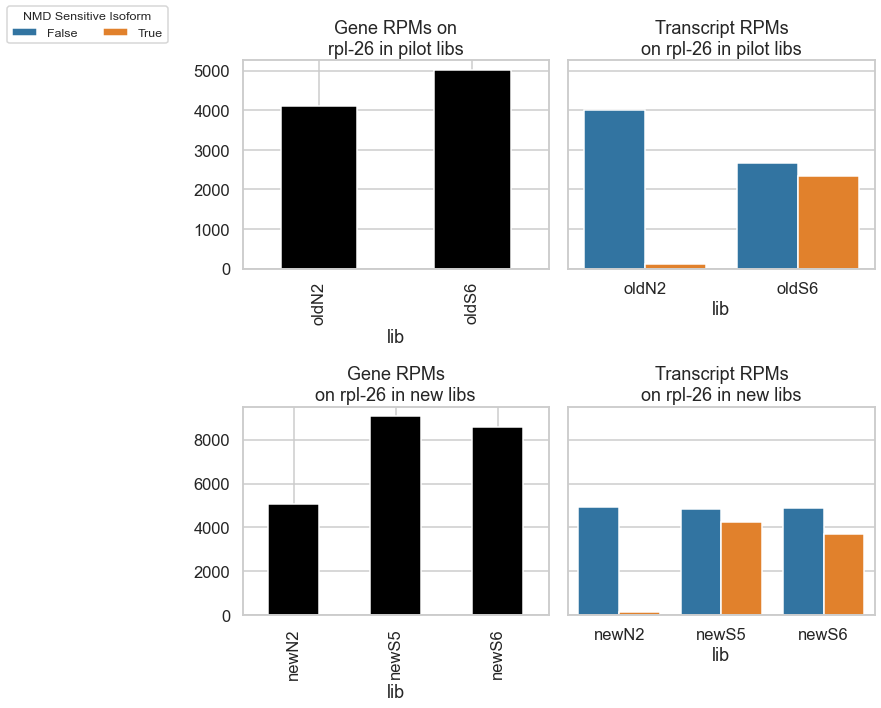

lib    chr_id  gene_id         NMD Sensitive Isoform
newN2  II      WBGene00004440  False                    4927.286008
                               True                      132.810944
newS5  II      WBGene00004440  False                    4815.358791
                               True                     4248.845992
newS6  II      WBGene00004440  False                    4892.324189
                               True                     3708.337057
Name: gene_t5group_rpm, dtype: float64

In [11]:
target_gene = 'rpl-26'
context = 'talk'  # 'paper' 'talk' 'poster'

nmd_sensitive_genes_and_txns = (('ubl-1', ['H06I04.4b.1']),
                                #('rpl-3', ['F13B10.2b']),
                                #('odc-1', ['K11C4.4.1']),
                                ('rpl-12', ['JC8.3c.2', 'JC8.3b']),
                                #('rpl-30', ['Y106G6H.3c.1']),
                                #('rpl-1', ['Y71F9AL.13b.4', 'Y71F9AL.13b.2']),
                                ('rpl-26', ['F28C6.7b.1']),
                                )

sea.set_style("whitegrid")
sea.set_context(context)
if context == 'paper':
    fig_size = (8, 8)
if context == 'talk':
    fig_size = (10, 10)
if context == 'poster':
    fig_size = (12, 12)
show_adapted_species = False

plot_column_suffix = "t5group_rpm"  # "t5group_rpm" or "rpm"
adapted_species_adjustment_factor = 5

old_df = old_df_raw.copy(deep=True)
new_df = new_df_raw.copy(deep=True)

for potential_target_gene, NMD_sensitive_txns in nmd_sensitive_genes_and_txns:
    if target_gene == potential_target_gene:
        old_df['NMD Sensitive Isoform'] = old_df['transcript_id'].isin(NMD_sensitive_txns)
        new_df['NMD Sensitive Isoform'] = new_df['transcript_id'].isin(NMD_sensitive_txns)

gene_df = compress_df(old_df,
                      keep_transcript_info=False,
                      ).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name'])
txn_df = compress_df(old_df,
                     keep_transcript_info=False,  # The 'NMD Sensitive Isoform' column will retain this info here!
                     additional_groupby_columns=['NMD Sensitive Isoform'],
                     ).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name', 'NMD Sensitive Isoform'])


fig, axes = plt.subplots(2, 2, figsize=fig_size,
                         sharex=False,
                         sharey='row')
axes = axes.flatten().T

adapt_df = gene_df.xs((target_gene, '+'), level=('gene_name', 't5'))[f'gene_{plot_column_suffix}'] / adapted_species_adjustment_factor
unadapt_df = gene_df.xs((target_gene, '-'), level=('gene_name', 't5'))[f'gene_{plot_column_suffix}']
if show_adapted_species:
    plot_df = pd.merge(unadapt_df,adapt_df, on=adapt_df.index.names, how='outer',
                       suffixes=('_unadapted', '_adapted')).fillna(0)
else:
    plot_df = unadapt_df
plot_df.reset_index(level=('gene_id', 'chr_id')).sort_index(level=['gene_name', 'lib']).plot(kind='bar', stacked=True, color=['k', 'red'], ax=axes[0], legend=None)
axes[0].set_title(f"Gene RPMs on\n{target_gene} in pilot libs")


adapt_df = txn_df.xs((target_gene, '+'), level=('gene_name', 't5'))[f'gene_{plot_column_suffix}'] / adapted_species_adjustment_factor
unadapt_df = txn_df.xs((target_gene, '-'), level=('gene_name', 't5'))[f'gene_{plot_column_suffix}']
if show_adapted_species:
    plot_df = pd.merge(unadapt_df,adapt_df, on=adapt_df.index.names, how='outer',
                       suffixes=('_unadapted', '_adapted')).fillna(0)
else:
    plot_df = unadapt_df
# plot_df.reset_index(level='gene_id').sort_index(level=['NMD Sensitive Isoform', 'lib',]).plot(kind='bar', stacked=True, color=['k', 'red'], ax=axes[1], legend=None)
sea.barplot(plot_df.reset_index(),
            x='lib',
            y=f'gene_{plot_column_suffix}',
            hue='NMD Sensitive Isoform',
            ax=axes[1])
# bar_plot_save_path = f"{target_gene_folder_path}/barPlot_geneRPMS_{target_gene}"
axes[1].set_title(f"Transcript RPMs\non {target_gene} in pilot libs")
axes[1].get_legend().remove()

# New libs!

gene_df = compress_df(new_df,
                      keep_transcript_info=False,
                      ).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name'])
txn_df = compress_df(new_df,
                     keep_transcript_info=False,  # The 'NMD Sensitive Isoform' column will retain this info here!
                     additional_groupby_columns=['NMD Sensitive Isoform'],
                     ).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name', 'NMD Sensitive Isoform'])

adapt_df = gene_df.xs((target_gene, '+'), level=('gene_name', 't5'))[f'gene_{plot_column_suffix}'] / adapted_species_adjustment_factor
unadapt_df = gene_df.xs((target_gene, '-'), level=('gene_name', 't5'))[f'gene_{plot_column_suffix}']
if show_adapted_species:
    plot_df = pd.merge(unadapt_df,adapt_df, on=adapt_df.index.names, how='outer',
                       suffixes=('_unadapted', '_adapted')).fillna(0)
else:
    plot_df = unadapt_df
plot_df.reset_index(level=('gene_id', 'chr_id')).sort_index(level=['gene_name', 'lib']).plot(kind='bar', stacked=True, color=['k', 'red'], ax=axes[2], legend=None)
# bar_plot_save_path = f"{target_gene_folder_path}/barPlot_geneRPMS_{target_gene}"
axes[2].set_title(f"Gene RPMs\non {target_gene} in new libs")

adapt_df = txn_df.xs((target_gene, '+'), level=('gene_name', 't5'))[f'gene_{plot_column_suffix}'] / adapted_species_adjustment_factor
unadapt_df = txn_df.xs((target_gene, '-'), level=('gene_name', 't5'))[f'gene_{plot_column_suffix}']
if show_adapted_species:
    plot_df = pd.merge(unadapt_df,adapt_df, on=adapt_df.index.names, how='outer',
                       suffixes=('_unadapted', '_adapted')).fillna(0)
else:
    plot_df = unadapt_df
# plot_df.reset_index(level='gene_id').sort_index(level=['NMD Sensitive Isoform', 'lib',]).plot(kind='bar', stacked=True, color=['k', 'red'], ax=axes[3], legend=None)
sea.barplot(plot_df.reset_index(),
            x='lib',
            y=f'gene_{plot_column_suffix}',
            hue='NMD Sensitive Isoform',
            ax=axes[3])
# bar_plot_save_path = f"{target_gene_folder_path}/barPlot_geneRPMS_{target_gene}"
axes[3].set_title(f"Transcript RPMs\non {target_gene} in new libs")
axes[3].get_legend().remove()
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0, 1),
           loc="upper right",
           bbox_transform=fig.transFigure, ncol=2,
           title=f'NMD Sensitive Isoform',
           fontsize='x-small',
           title_fontsize='x-small')
plt.tight_layout()
save_path = f"./output_files/isoform_plots/{npCommon.get_dt()}_{target_gene}_rpms.barPlots"
for file_type in ['.svg', '.png']:
    plt.savefig(save_path + file_type,
                dpi=300)
plt.show()
plot_df

In [19]:
import matplotlib
def plot_tails(target_gene, df_to_plot, plot_type='ecdfPlot', show_adapted_species = False, save_dir=".", width_per_lib=4, height=8):
    """
    
    :param target_gene:
    :param plot_type: 'boxPlot' or 'ecdfPlot' or 'violinPlot'
    :param show_adapted_species: True or False
    :return: 
    """
    global plot_df, potential_target_gene, NMD_sensitive_txns, fig, axes, save_path, file_type
    lib_set = "all"
    target_df = df_to_plot
    plot_df = target_df.set_index(['lib', 'gene_id', 'gene_name', 't5', 'transcript_id']).xs((target_gene, '-'), level=(
    'gene_name', 't5')).reset_index()
    for potential_target_gene, NMD_sensitive_txns in nmd_sensitive_genes_and_txns:
        if target_gene == potential_target_gene:
            plot_df['NMD Sensitive Isoform'] = plot_df['transcript_id'].isin(NMD_sensitive_txns)
    unique_libs = plot_df.lib.unique()
    unique_lib_count = len(unique_libs)
    fig, axes = plt.subplots(1, unique_lib_count, figsize=(width_per_lib * unique_lib_count, height),
                             sharex='all',
                             sharey='all')
    plt.suptitle(f"Poly(A) Tail Lengths for {target_gene}")
    sea.set_style("whitegrid")
    sea.set_context("poster")
    ticks = [10, 100, 1000]
    tick_line_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    tick_lines = [a * b for a, b in product(ticks, tick_line_factors)]
    tick_labels = [str(int(label)) if label in ticks else '' for label in tick_lines]
    for i, unique_lib in enumerate(unique_libs):
        if plot_type == 'boxPlot':
            sea.boxplot(plot_df.query(f"lib == '{unique_lib}'"),
                        y='polya_length',
                        x='NMD Sensitive Isoform',
                        ax=axes[i])
            axes[i].set_yscale('log')
            axes[i].set_yticks(tick_lines)
            axes[i].set_ylim((2, 500))
            axes[i].set_yticklabels(tick_labels)
        elif plot_type == 'violinPlot':
            try:
                sea.violinplot(plot_df.query(f"lib == '{unique_lib}'"),
                               y='polya_length',
                               x='lib',
                               hue='NMD Sensitive Isoform',
                               ax=axes[i],
                               split=True)
            except ValueError:
                sea.violinplot(plot_df.query(f"lib == '{unique_lib}'"),
                               y='polya_length',
                               x='lib',
                               hue='NMD Sensitive Isoform',
                               ax=axes[i])
            axes[i].set_yscale('log')
            axes[i].set_yticks(tick_lines)
            axes[i].set_yticklabels(tick_labels)
            axes[i].get_legend().remove()
        elif plot_type == 'ecdfPlot':
            sea.ecdfplot(plot_df.query(f"lib == '{unique_lib}'"),
                         x='polya_length',
                         hue='NMD Sensitive Isoform',
                         ax=axes[i],
                         linewidth=5,
                         )
            axes[i].set_xscale('log')
            axes[i].set_xticks(tick_lines)
            axes[i].set_xticklabels(tick_labels)
            axes[i].set_xlim((5, 500))
            axes[i].get_legend().remove()
        else:
            raise NotImplementedError(
                f"{plot_type} is not currently supported! b/c I haven't coded it or you have a typo...")
        lib_converter = {'oldN2': 'Wildtype (pilot)',
                         'oldS6': 'Δsmg-6 (pilot)',
                         'newN2': 'Wildtype (new)',
                         'newS5': 'Δsmg-5 (new)',
                         'newS6': 'Δsmg-6 (new)',
                         }
        axes[i].set_title(f"{lib_converter[unique_lib]}")
    if plot_type == 'ecdfPlot': 
        plt.legend(["True", "False"],
                   bbox_to_anchor=(0.9, 0.99),
                   loc="upper right",
                   bbox_transform=fig.transFigure, ncol=2,
                   title=f'NMD Sensitive Isoform',
                   handlelength=1.5,
                   fontsize='x-small',
                   title_fontsize='x-small',)
    elif plot_type == 'violinPlot':
        handles, labels = axes[-1].get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(1, 1),
                   loc="upper right",
                   bbox_transform=fig.transFigure, ncol=2,
                   title=f'NMD Sensitive Isoform',
                   fontsize='x-small',
                   title_fontsize='x-small')
    plt.tight_layout()
    save_path = f"{save_dir}/{npCommon.get_dt()}_{target_gene}_tails_{lib_set}.{plot_type}"
    for file_type in ['.svg', '.png']:
        plt.savefig(save_path + file_type,
                    dpi=300)
    plt.show()

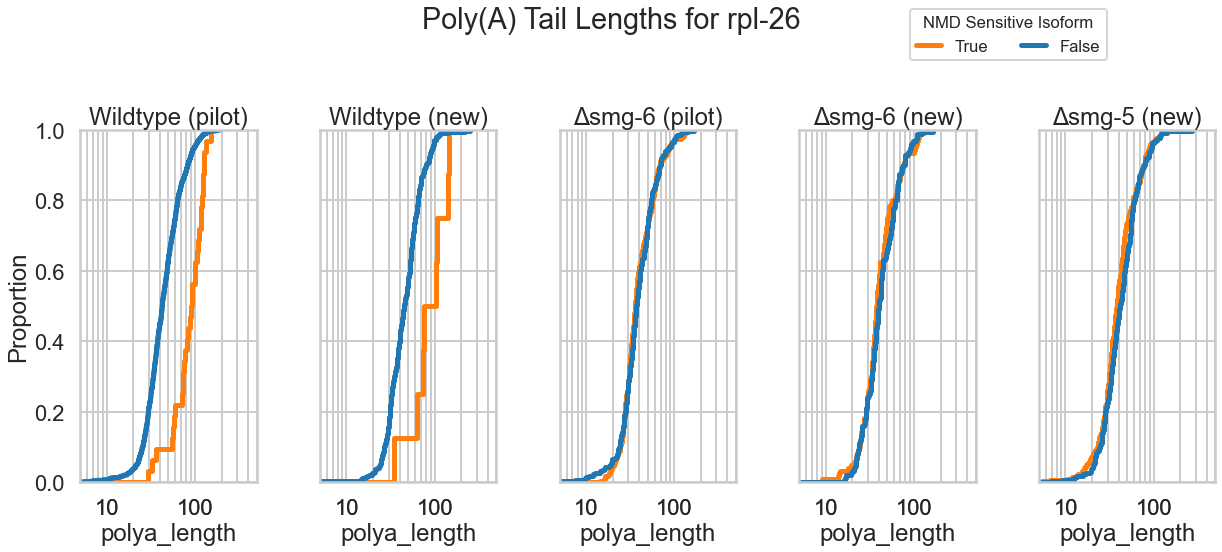

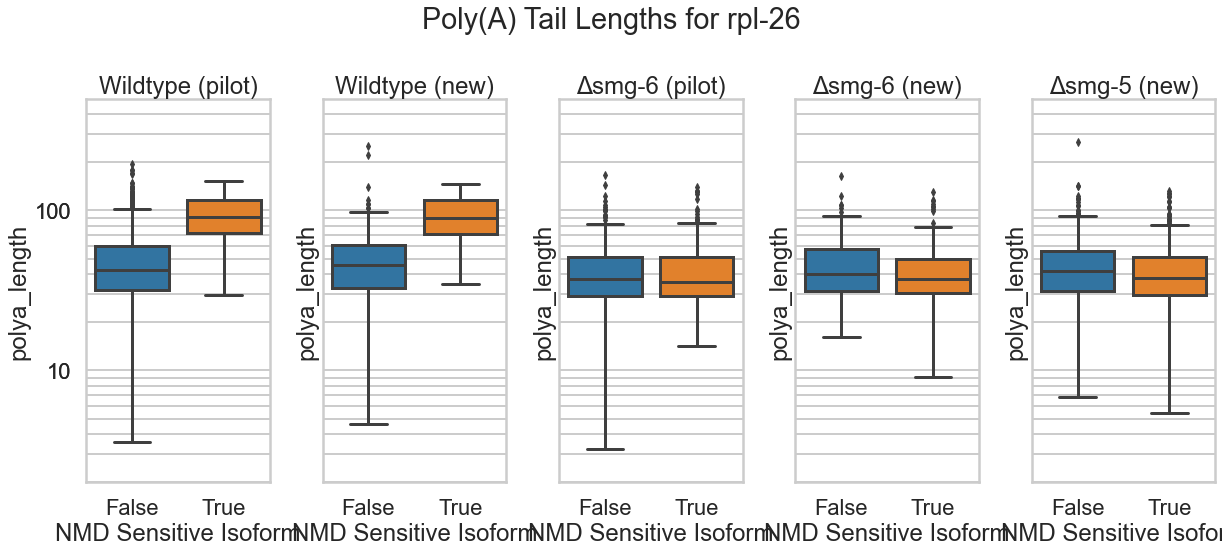

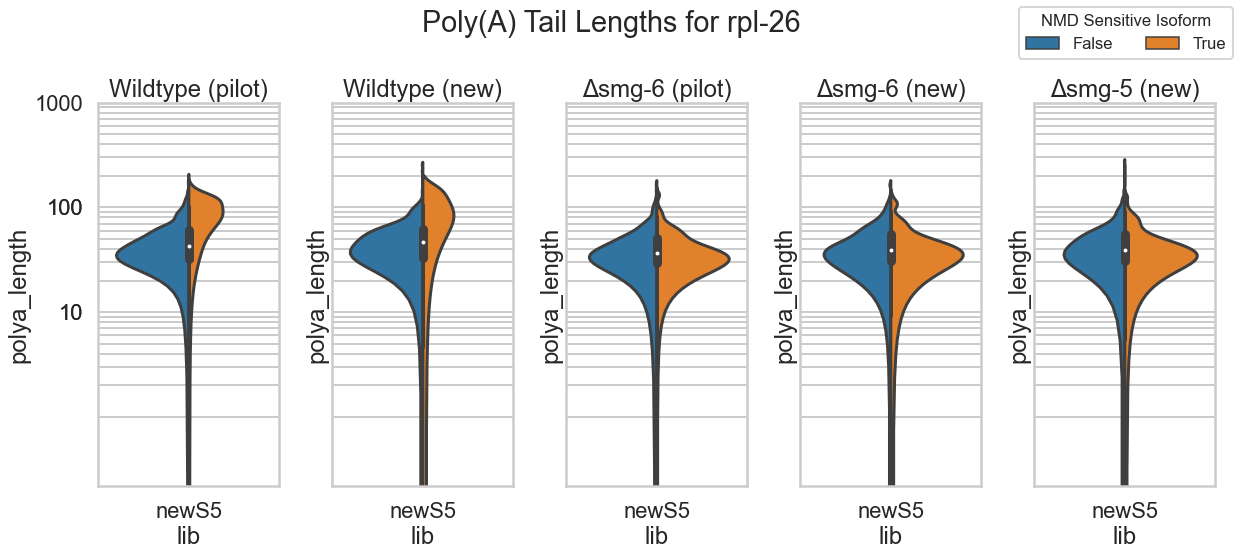

In [21]:
nmd_sensitive_genes_and_txns = (# ('ubl-1', ['H06I04.4b.1']),
                                #('rpl-3', ['F13B10.2b']),
                                #('odc-1', ['K11C4.4.1']),
                                # ('rpl-12', ['JC8.3c.2', 'JC8.3b']),
                                #('rpl-30', ['Y106G6H.3c.1']),
                                #('rpl-1', ['Y71F9AL.13b.4', 'Y71F9AL.13b.2']),
                                ('rpl-26', ['F28C6.7b.1']),
                                )

target_genes = [gene for gene, _ in nmd_sensitive_genes_and_txns]
plot_types = [
    'ecdfPlot',
    'boxPlot',
    'violinPlot',
]

df_raw = pd.concat([
    oldN2_df,
    newN2_df,
    oldS6_df,
    newS6_df,
    newS5_df,
])

for gene, plot_kind in product(target_genes, plot_types):
    target_gene_folder_path = f"./output_files/isoform_plots/{npCommon.get_dt()}_tailPlots_from_{gene}"
    try:
        os.mkdir(target_gene_folder_path)
    except FileExistsError:
        pass
    plot_df = df_raw.copy(deep=True)
    plot_tails(gene, plot_df, plot_type=plot_kind,
               save_dir=target_gene_folder_path,
               width_per_lib=3.5,
               height=8)

In [392]:
# Make a scatter plot of isoforms and their RPMS between N2 and smg-5/6 treatments. Maybe this will better pick out things like rpl-12 which I have missed but is obviously a great target!
# This will be a little annoying b/c i'll need to split and remerge the columns!
plot_col = 'transcript_rpm'

df = df_raw.copy(deep=True)
df = df.query("lib == 'oldN2' | lib == 'oldS6'")
df = compress_df(df, group_by_t5=False)

lib_names = df.index.get_level_values('lib').to_series().unique()

dfs = []
for lib in lib_names:
    dfs.append(df.query(f"lib == '{lib}'").reset_index(level='lib')[plot_col].rename(f"{plot_col}_{lib}"))
plot_df = pd.concat(dfs, axis=1).fillna(0)

fig = px.scatter(plot_df.reset_index(),
                 x=f'{plot_col}_{lib_names[0]}',
                 y=f'{plot_col}_{lib_names[1]}',
                 hover_name='gene_name',
                 hover_data=['transcript_id'])
fig.show(renderer='browser')

Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [transcript_id]


Counting reads per transcript: 100%|██████████| 23081/23081 [00:00<00:00, 51389.94it/s]


In [ ]:
# A stacked bar plots of isoforms would also be really great. How easy would this be?